<a href="https://colab.research.google.com/github/pabloac31/TFG/blob/master/cifar10_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Clone the repository**

In [1]:
! git clone https://github.com/pabloac31/TFG.git
%cd TFG

Cloning into 'TFG'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 240 (delta 33), reused 14 (delta 7), pack-reused 183
Receiving objects: 100% (240/240), 217.30 MiB | 13.49 MiB/s, done.
Resolving deltas: 100% (126/126), done.
Checking out files: 100% (30/30), done.
/content/TFG


**Using Tensorflow v1**

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Import libraries**

In [0]:
from cifar10_models import *
from utils import *
from adversarial_attacks import *

**Use CUDA if available for increase speed**

In [4]:
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


**Create dataloaders**

Load CIFAR10 test images as tensors of size NxCxHxW normalized with CIFAR10 mean and std.

In [5]:
test_loader = testloader_cifar10('./data', batch_size=256, shuffle=False)  # Dataloader for testing the model 
adv_loader = testloader_cifar10('./data', batch_size=1)                    # Dataloader for adversarial attacks
univ_loader = testloader_cifar10('./data', batch_size=1000, shuffle=False) # Dataloader for universal attack
full_loader = testloader_cifar10('./data', batch_size=10000, shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**Load models pretrained on CIFAR10**

In [0]:
resnet = resnet50(pretrained=True)
densenet = densenet169(pretrained=True)
mobnet = mobilenet_v2(pretrained=True)
iv3 = inception_v3(pretrained=True)

**Test models**

In [0]:
acc = test_model(resnet, device, test_loader)
print('\nAccuracy on CIFAR10 test set: ', acc)

100%|██████████| 40/40 [00:05<00:00,  7.40it/s]


Accuracy on CIFAR10 test set:  0.9212


**Set method parameters**

In [0]:
params_fgsm = {'epsilon': 0.01, 'clip': True}
params_deepfool = {'num_classes': 10, 'overshoot': 0.01, 'max_iter': 50, 'p': 2, 'clip': True}
params_sparsefool = {'delta': 255, 'lambda_': 3.0, 'max_iter': 50, 'epsilon': 0.02}
params_opa = {'dim': 3, 'target_label': None, 'iters': 100, 'pop_size': 400, 'verbose': True}

**Test methods**

In [0]:
image, label = next(iter(adv_loader))

scores = test_method(mobnet, device, image, label, method='one_pixel_attack', params=params_opa)

**Perform a complete attack and show results**

In [0]:
adv_examples = attack_model(mobnet, device, univ_loader, 'one_pixel_attack', params_opa, iters=10)

**Prepare datasets for universal attack**

In [7]:
dataset, labels = next(iter(univ_loader))
print(dataset.size())

testset, labels_test = next(iter(full_loader))
print(testset.size())

torch.Size([1000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


In [8]:
norm = 0.0
for im,_ in adv_loader:
  norm += im.norm()
print(norm / len(adv_loader))

tensor(66.7882)


**Obtain an universal perturbation**

In [12]:
v, fooling_rate = universal_perturbation(dataset, labels, iv3, device, delta=0.2, xi=3*5, max_iter_uni=10, p=2)
print('Fooling rate on X:', fooling_rate)

  0%|          | 0/1000 [00:00<?, ?it/s]

Starting pass number  0


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

FOOLING RATE =  0.852
Total time: 130.9203
Total iters: 1
Norm of the univ. perturbation: tensor(15., device='cuda:0')
Fooling rate on X: 0.852


In [16]:
univ_fool_rate(iv3, device, testset, v, batch_size=250)

  0%|          | 0/40 [00:00<?, ?it/s]


RuntimeError: ignored

In [0]:
#torch.save(v, 'iv3_15.pt') 
v = torch.load('iv3_15.pt')

RuntimeError: ignored

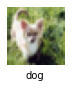

In [15]:
show_univ_examples(5, iv3, device, v)

In [0]:
def show_univ_examples(num_images, model, device, v):
  f = plt.figure()
  i = 0
  for img, label in adv_loader:

    if i >= num_images:
      break
    i += 1

    img = img.to(device)
    label = label.to(device)

    y = model(img)
    init_pred = y.max(1, keepdim=True)[1]

    f.add_subplot(3,num_images,i)
    plt.axis('off')
    f.text(.03 + (0.8/num_images)*i, .62, cifar10_classes[label.item()], ha='center')
    plt.imshow(displayable(img.cpu()))

    adv_x = img + v
    y_adv = model(adv_x)
    adv_pred = y_adv.max(1, keepdim=True)[1]

    f.add_subplot(3,num_images,2*num_images+i)
    plt.axis('off')
    f.text(.03 + (0.8/num_images)*i, .1, cifar10_classes[adv_pred.item()], ha='center')
    plt.imshow(displayable(adv_x.cpu()))

  f.add_subplot(3,num_images,num_images + np.ceil(num_images/2))
  plt.axis('off')
  f.text(0.7, 0.5, 'Univ. perturbation', ha='center')
  plt.imshow(displayable(v.cpu()))

  plt.show(block=True)

tensor(15., device='cuda:0')


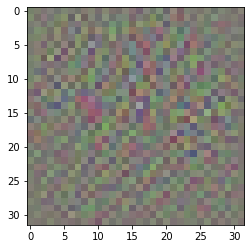

In [30]:
plt.imshow(displayable(v.cpu()))
print(torch.norm(v))

In [0]:
def universal_perturbation(dataset, labels, model, device, delta=0.2, xi=10, max_iter_uni=10, p=2, num_classes=10, overshoot=0.02, max_iter_df=10, v_ini=None):

  time_ini = time.time()
  
  # Initialize the network and set the model in evaluation mode.
  model = model.to(device).eval()
  dataset = dataset.to(device)
  labels = labels.to(device)

  v = v_ini.clone() if v_ini is not None else torch.zeros((1, dataset.size()[1], dataset.size()[2], dataset.size()[3])).to(device)
  fooling_rate = 0.0
  num_images = dataset.size()[0]

  v_best = v.clone()
  fool_rate_best = 0.0
  
  itr = 0
  while fooling_rate < 1-delta and itr < max_iter_uni:

    # Shuffle the dataset
    order = np.arange(num_images)
    np.random.shuffle(order)
    dataset[np.arange(num_images)] = dataset[order]
    labels[np.arange(num_images)] = labels[order]
    
    print('Starting pass number ', itr)

    # Go through the data set and compute the perturbation increments sequentially
    for k in pbar(range(num_images)):
      cur_img = dataset[k:(k+1), :, :, :]
      label = labels[k]

      pred_label = model(cur_img).max(1, keepdim=True)[1].item()

      if pred_label == label.item() and model(cur_img + v).max(1, keepdim=True)[1].item() == pred_label:

        # Compute adversarial perturbation
        _, _, dr, loop_i = deepfool(model, device, cur_img + v, num_classes=num_classes, overshoot=overshoot, lambda_fac=1+overshoot, max_iter=max_iter_df, p=p)

        # Make sure it converged...
        if loop_i < max_iter_df-1:
          v = v + dr

          # Project on the lp ball centered at 0 and of radius xi
          if p == 2:
            v = v * min(1, xi / v.norm())
          elif p == np.inf:
            v = torch.sign(v) * torch.min(torch.abs(v), torch.full_like(v, xi))

    itr += 1
    
    fooling_rate = univ_fool_rate(model, device, dataset, v, batch_size=100)
    print('FOOLING RATE = ', fooling_rate)

    if fooling_rate > fool_rate_best:
      v_best = v.clone()
      fool_rate_best = fooling_rate

  time_end = time.time()
  total_time = time_end-time_ini
  print('Total time: {:.4f}'.format(total_time))
  print('Total iters:', itr)
  print('Norm of the univ. perturbation:', torch.norm(v, p=p))

  return v_best, fool_rate_best

In [0]:
def univ_fool_rate(model, device, dataset, v, batch_size=250):
    
    model = model.to(device).eval()
    dataset = dataset.to(device)

    num_images = dataset.size(0)
    
    # Perturb the dataset with the universal perturbation v
    dataset_perturbed = (dataset + v).to(device)

    num_batches = np.int(np.ceil(np.float(num_images) / np.float(batch_size)))
    fooling_rate = 0.0

    # Compute the estimated labels in batches
    for ii in pbar(range(num_batches)):
        m = (ii * batch_size)
        M = min((ii+1)*batch_size, num_images)

        est_labels_orig = torch.argmax(model(dataset[m:M, :, :, :]), axis=1)
        est_labels_pert = torch.argmax(model(dataset_perturbed[m:M, :, :, :]), axis=1)
        
        fooling_rate += torch.sum(est_labels_pert != est_labels_orig).item()

    # Compute the fooling rate
    fooling_rate = fooling_rate / float(num_images)
    return fooling_rate

In [0]:
def test_method(model, device, img, label, method, params):

  img = img.clone()

  model = model.to(device).eval()

  x = img.to(device)
  label = label.to(device)

  if method in ['fgsm', 'deepfool', 'sparsefool']:
    x.requires_grad = True

  y = model(x)
  init_pred = y.max(1, keepdim=True)[1]
  x_conf = F.softmax(y, dim=1).max(1, keepdim=True)[0].item()  

  if init_pred.item() != label.item():
    print("Wrong classification...")
    return

  # Call method
  if method == 'fgsm':
    adv_x, pert_x = fgsm(model, x, label, y, params["epsilon"], params["clip"])

  elif method == 'deepfool':
    _, adv_x, pert_x, n_iter = deepfool(model, device, x, params["num_classes"], overshoot=params["overshoot"], max_iter=params["max_iter"], p=params["p"], clip=params["clip"])

  elif method == 'sparsefool':
    # Generate lower and upper bounds
    delta = params["delta"]
    lb, ub =  valid_bounds(x, delta, dataset='cifar10')
    lb = lb[None, :, :, :].to(device)
    ub = ub[None, :, :, :].to(device)
    adv_x, pert_x, n_iter = sparsefool(model, device, x, label.item(), lb, ub, params["lambda_"], params["max_iter"], params["epsilon"])

  elif method == 'one_pixel_attack':
    adv_x, n_iter, scores = one_pixel_attack(model, device, x, label.item(), params["dim"], params["target_label"], params["iters"], params["pop_size"], params["verbose"])
    pert_x = adv_x - x

  y_adv = model(adv_x)
  adv_pred = y_adv.max(1, keepdim=True)[1]
  adv_x_conf = F.softmax(y_adv, dim=1).max(1, keepdim=True)[0].item()  

  if adv_pred.item() == label.item():
    print("Attack failed...")

  else:
    print("Succesful attack!")

  f = plt.figure()
  f.add_subplot(1,3,1)
  plt.title('Original image')
  plt.axis('off')
  f.text(.25, .3, cifar10_classes[label.item()] + ' ({:.2f}%)'.format(x_conf*100), ha='center')
  plt.imshow(displayable(img))
  f.add_subplot(1,3,2)
  plt.title('Perturbation')
  plt.axis('off')
  plt.imshow(displayable(pert_x.cpu().detach()))
  f.add_subplot(1,3,3)
  plt.title('Adv. image')
  plt.axis('off')
  f.text(.8, .3, cifar10_classes[adv_pred.item()] + ' ({:.2f}%)'.format(adv_x_conf*100), ha='center')
  plt.imshow(displayable(adv_x.cpu().detach()))
  plt.show(block=True)

  if method in ['deepfool',  'sparsefool', 'one_pixel_attack']:
    print('Number of iterations needed: ', n_iter)

  if method == 'sparsefool':
    pert_pixels = pert_x.flatten().nonzero().size(0)
    print('Number of perturbed pixels: ', pert_pixels) 

  if method == 'one_pixel_attack':
    return scores

In [0]:
def attack_model(model, device, test_loader, method, params, p=2, iters=10000, dataset='cifar10'):

  # Initialize the network and set the model in evaluation mode.
  model = model.to(device).eval()

  # Initialize stat counters
  correct = 0
  incorrect = 0
  confidence = 0
  total_time = 0
  ex_robustness = 0
  model_robustness = 0
  method_iters = 0
  n_pert_pixels = []
  adv_examples = []

  i = 0

  # Loop (iters) examples in test set
  for data, target in pbar(test_loader):
    if i >= iters:
      break
    i += 1

    # Send the data and label to the device
    data, target = data.to(device), target.to(device)

    # Set requires_grad attribute of tensor (important for some attacks)
    if method in ['fgsm', 'deepfool', 'sparsefool']:
        data.requires_grad = True

    # Forward pass the data through the model
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    # If the initial prediction is wrong, dont botter attacking
    if init_pred.item() != target.item():
      continue

    if method == 'fgsm':
        # Call FGSM attack
        time_ini = time.time()
        perturbed_data, _ = fgsm(model, data, target, output, params["epsilon"], params["clip"], dataset)
        time_end = time.time()
        total_time += time_end-time_ini

    elif method == 'deepfool':
        # Call DeepFool attack
        time_ini = time.time()
        _, perturbed_data, _, n_iter = deepfool(model, device, data, params["num_classes"], overshoot=params["overshoot"], max_iter=params["max_iter"], p=params["p"], clip=params["clip"])
        time_end = time.time()
        total_time += time_end-time_ini
        method_iters += n_iter

    elif method == 'sparsefool':
        # Generate lower and upper bounds
        delta = params["delta"]
        lb, ub =  valid_bounds(data, delta, dataset='cifar10')
        lb = lb[None, :, :, :].to(device)
        ub = ub[None, :, :, :].to(device)
        # Call SparseFool attack
        time_ini = time.time()
        perturbed_data, perturbation, n_iter = sparsefool(model, device, data, target.item(), lb, ub, params["lambda_"], params["max_iter"], params["epsilon"])
        time_end = time.time()
        total_time += time_end-time_ini
        method_iters += n_iter
        n_pert_pixels.append(perturbation.flatten().nonzero().size(0))

    elif method == 'one_pixel_attack':
        # Call one pixel attack
        time_ini = time.time()
        perturbed_data, n_iter, _ = one_pixel_attack(model, device, data, target.item(), params["dim"], params["target_label"], params["iters"], params["pop_size"], params["verbose"])
        time_end = time.time()
        total_time += time_end-time_ini
        method_iters += n_iter


    # Update model robustness
    # multiply by std to make it independent of the normalization used
    difference = de_scale(perturbed_data-data, dataset)
    if p == 2:
      adv_rob = torch.norm(difference)  # Frobenius norm (p=2)
      model_robustness += adv_rob / torch.norm(de_scale(data, dataset))
    elif p == np.inf:
      adv_rob = torch.norm(difference, float('inf'))  # Inf norm (p=inf)
      model_robustness += adv_rob / torch.norm(de_scale(data, dataset), float('inf'))
    ex_robustness += adv_rob
    
    # Re-classify the perturbed image
    output = model(perturbed_data)

    # Check for success
    final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    
    if final_pred.item() == target.item():
      correct += 1
    
    else:
      incorrect += 1
      # Update average confidence
      confidence += F.softmax(output, dim=1).max(1, keepdim=True)[0].item()  
      # Save some adv examples for visualization later
      if len(adv_examples) < 5:
        adv_examples.append( (init_pred.item(), final_pred.item(), data.detach().cpu(), perturbed_data.detach().cpu()) )

  # Calculate stats
  final_acc = correct / float(iters)  # len(test_loader)
  avg_confidence = confidence / float(incorrect)
  avg_time = total_time / float(correct+incorrect)
  avg_ex_robustness = ex_robustness / float(correct+incorrect)
  model_robustness = model_robustness / float(correct+incorrect)
  print("\n======== RESULTS ========")
  print("Test Accuracy = {} / {} = {:.4f}\nAverage confidence = {:.4f}\nAverage time = {:.4f}\nAverage magnitude of perturbations = {:.4f}\nModel robustness = {:.4f}"
    .format(correct, iters, final_acc, avg_confidence, avg_time, avg_ex_robustness, model_robustness))

  if method in ['deepfool', 'sparsefool', 'one_pixel_attack']:
    print("Avg. iters = {:.2f}".format(method_iters / float(correct+incorrect)))

  if method == 'sparsefool':
    print("Median num. of pixels perturbed = ", statistics.median(n_pert_pixels))
    print("Average num. of pixels perturbed = {:.2f}".format(statistics.mean(n_pert_pixels)))

  # Return adversarial examples
  return adv_examples